In [116]:
import json
import jsonlines
import pandas as pd
import numpy as np
import seaborn as sb

In [90]:
history_file = '../data/history_file_fairness_lottery_2agents.json'
recs_file = '../data/recs.csv'

In [91]:
recommender = pd.read_csv(recs_file, names=["User","Item","Score"])

In [92]:
history = []
with jsonlines.open(history_file) as reader:
    for obj in reader:
        history.append(obj)

In [93]:
accuracy_dict = {}
for line in history:
    results = line['choice_out']['results']
    results_list = []
    for item in results:
        results_list.append(item['item'])
    accuracy_dict[line['user']] = results_list 


In [94]:
print(accuracy_dict["0"])

['393', '676', '608', '542', '971', '136', '692', '78', '993', '598']


In [95]:
def lookupscore(user, item):
    user = int(user)
    item = int(item)
    score = recommender.loc[(recommender.User == user) & (recommender.Item == item)]["Score"]
    return float(score)

In [96]:
lookupscore(0, 542)

2.5344375385082785

Used this equation from [Wikipedia](https://en.wikipedia.org/wiki/Discounted_cumulative_gain#cite_note-4) to calculate Discounted Cumulative Gain.

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/3efe45491d555db398ed663107460f81d6ecaf1e)

In [97]:
def traditional_dcg(score_values):
    dcg_list = []
    for index, val in enumerate(score_values):
        if index > 0:
            dcg = score_values[index-1] + val/np.log2(index + 2) # add 2 not 1 b/c of undefined/0 issues
        else:
            dcg = val/np.log2(index + 2)
        dcg_list.append(dcg)
    return sum(dcg_list)

Another (newer) equation from [Wikipedia](https://en.wikipedia.org/wiki/Discounted_cumulative_gain#cite_note-4) to calculate Discounted Cumulative Gain. Using this calculation of NCDG ends up showing much more fluctuation in the results. This makes sense because this equation places a greater focus on relevance.

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/d7ce96a2916c5eb451c4da5a1bce54fc9a2f7894)

In [98]:
def new_dcg(score_values):
    dcg_list = []
    for index, val in enumerate(score_values): 
        dcg = (2**val - 1)/np.log2(index + 2) # add 2 not 1 b/c of undefined/0 issues
        dcg_list.append(dcg)
    return sum(dcg_list)

In [99]:
def ndcg(scores1, scores2, new=False):
    if new:
        return new_dcg(scores1)/new_dcg(scores2)
    else:
        return traditional_dcg(scores1)/traditional_dcg(scores2)

In [113]:
users = []
ndcg_traditional_values = []
ndcg_new_values = []
for user, items in accuracy_dict.items():
    generated_scores = []
    for item in items:
        generated_scores.append(lookupscore(user, item))
    ideal_scores = []
    for score in recommender.loc[(recommender.User == int(user))]["Score"].sort_values(ascending=False):
        ideal_scores.append(score)
    users.append(user)
    ndcg_traditional_values.append(ndcg(generated_scores, ideal_scores))
    ndcg_new_values.append(ndcg(generated_scores, ideal_scores, new=True))

stored_values = {"Users":users,"Traditional":ndcg_traditional_values,"New":ndcg_new_values}

In [114]:
ncdg_data = pd.DataFrame(stored_values)

<Axes: >

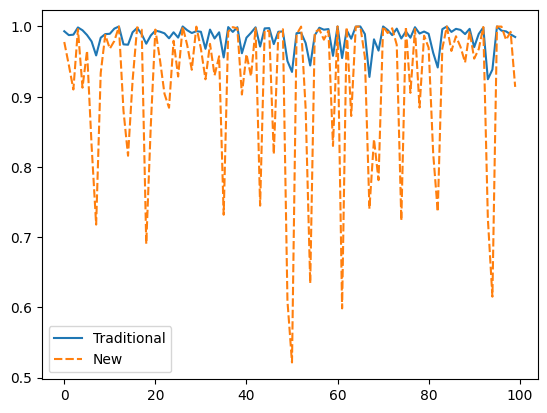

In [117]:
sb.lineplot(ncdg_data)